<a href="https://colab.research.google.com/github/alex-smith-uwec/NLP_Spring2025/blob/main/Inauguration_TF_IDF_Scikit_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF with Scikit-Learn
This notebook is inspired by one developed by [Melanie Walsh](https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html)

 A popular and effective method for text analysis is called *term frequency–inverse document frequency*, often abbreviated *tf-idf*. Tf-idf is a method that tries to identify the most distinctively frequent or significant words in documents across a corpus.

In this lesson, we're going to learn how to calculate tf-idf scores using a collection of plain text (.txt) files and the Python library scikit-learn, which has a quick and nifty module called [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In this notebook we will calculate and normalize tf-idf scores for U.S. Inaugural Addresses with scikit-learn.

## Dataset

### U.S. Inaugural Addresses

<blockquote class="epigraph" style=" padding: 10px">

This is the meaning of our liberty and our creed; why men and women and children of every race and every faith can join in celebration across this magnificent Mall, and why a man whose father less than 60 years ago might not have been served at a local restaurant can now stand before you to take a most sacred oath.  So let us mark this day with remembrance of who we are and how far we have traveled.
<p class ="attribution">—Barack Obama, Inaugural Presidential Address, January 2009
    </p>
    
</blockquote>

During Barack Obama's Inaugural Address in January 2009, he mentioned "women" four different times, including in the passage quoted above. How distinctive is Obama's inclusion of women in this address compared to all other U.S. Presidents? This is one of the questions that we're going to try to answer with tf-idf.

## Breaking Down the TF-IDF Formula

But first, let's quickly discuss the tf-idf formula. The idea is pretty simple.

**tf-idf = term_frequency * inverse_document_frequency**

**term_frequency** = number of times a given term appears in document

**inverse_document_frequency** = log(total number of documents / number of documents with term) + 1**\***

You take the number of times a term occurs in a document (term frequency). Then you take the number of documents in which the same term occurs at least once divided by the total number of documents (document frequency), and you flip that fraction on its head (inverse document frequency). Then you multiply the two numbers together (term_frequency * inverse_document_frequency).

The reason we take the *inverse*, or flipped fraction, of document frequency is to boost the rarer words that occur in relatively few documents. Think about the inverse document frequency for the word "said" vs the word "pigeon." The term "said" appears in 13 (document frequency) of 14 (total documents) *Lost in the City* stories (14 / 13 --> a smaller inverse document frequency) while the term "pigeons" only occurs in 2 (document frequency) of the 14 stories (total documents) (14 / 2 --> a bigger inverse document frequency, a bigger tf-idf boost).

*There are a bunch of slightly different ways that you can calculate inverse document frequency. The version of idf that we're going to use is the [scikit-learn default](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), which uses "smoothing" aka it adds a "1" to the numerator and denominator:

**inverse_document_frequency**  = log((1 + total_number_of_documents) / (number_of_documents_with_term +1)) + 1

<div class="margin sidebar" style=" padding: 10px">

> If smooth_idf=True (the default), the constant “1” is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions: idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1.  
> -[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)

</div>

## TF-IDF with scikit-learn

[scikit-learn](https://scikit-learn.org/stable/index.html), imported as `sklearn`, is a popular Python library for machine learning approaches such as clustering, classification, and regression. Though we're not doing any machine learning in this lesson, we're nevertheless going to use scikit-learn's `TfidfVectorizer` and `CountVectorizer`.

Install scikit-learn (not necessary in Colab)

In [ ]:
# !pip install sklearn

Import necessary modules and libraries

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### Set Directory Path

Below we're setting the directory filepath that contains all the text files that we want to analyze.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses_2"

In [4]:
file_names=!ls {my_path}
file_names=sorted(file_names)
# print(file_names)

In [ ]:
file_names

['01_washington_1789.txt\t       21_grant_1869.txt\t       41_truman_1949.txt',
 '02_washington_1793.txt\t       22_grant_1873.txt\t       42_eisenhower_1953.txt',
 '03_adams_john_1797.txt\t       23_hayes_1877.txt\t       43_eisenhower_1957.txt',
 '04_jefferson_1801.txt\t       24_garfield_1881.txt\t       44_kennedy_1961.txt',
 '05_jefferson_1805.txt\t       25_cleveland_1885.txt\t       45_johnson_1965.txt',
 '06_madison_1809.txt\t       26_harrison_1889.txt\t       46_nixon_1969.txt',
 '07_madison_1813.txt\t       27_cleveland_1893.txt\t       47_nixon_1973.txt',
 '08_monroe_1817.txt\t       28_mckinley_1897.txt\t       48_carter_1977.txt',
 '09_monroe_1821.txt\t       29_mckinley_1901.txt\t       49_reagan_1981.txt',
 '10_adams_john_quincy_1825.txt  30_roosevelt_theodore_1905.txt  50_reagan_1985.txt',
 '11_jackson_1829.txt\t       31_taft_1909.txt\t\t       51_bush_george_h_w_1989.txt',
 '12_jackson_1833.txt\t       32_wilson_1913.txt\t       52_clinton_1993.txt',
 '13_van_buren_1

In [5]:
# Split combined string by tabs and newlines, then filter out any empty strings
combined_string = ' '.join(file_names)
file_list = [name.strip() for name in combined_string.split() if name.strip() and '.' in name]

# Remove the extension from each file name
text_titles = sorted([name.split('.')[0] for name in file_list])



In [6]:
text_titles

['01_washington_1789',
 '02_washington_1793',
 '03_adams_john_1797',
 '04_jefferson_1801',
 '05_jefferson_1805',
 '06_madison_1809',
 '07_madison_1813',
 '08_monroe_1817',
 '09_monroe_1821',
 '10_adams_john_quincy_1825',
 '11_jackson_1829',
 '12_jackson_1833',
 '13_van_buren_1837',
 '14_harrison_1841',
 '15_polk_1845',
 '16_taylor_1849',
 '17_pierce_1853',
 '18_buchanan_1857',
 '19_lincoln_1861',
 '20_lincoln_1865',
 '21_grant_1869',
 '22_grant_1873',
 '23_hayes_1877',
 '24_garfield_1881',
 '25_cleveland_1885',
 '26_harrison_1889',
 '27_cleveland_1893',
 '28_mckinley_1897',
 '29_mckinley_1901',
 '30_roosevelt_theodore_1905',
 '31_taft_1909',
 '32_wilson_1913',
 '33_wilson_1917',
 '34_harding_1921',
 '35_coolidge_1925',
 '36_hoover_1929',
 '37_roosevelt_franklin_1933',
 '38_roosevelt_franklin_1937',
 '39_roosevelt_franklin_1941',
 '40_roosevelt_franklin_1945',
 '41_truman_1949',
 '42_eisenhower_1953',
 '43_eisenhower_1957',
 '44_kennedy_1961',
 '45_johnson_1965',
 '46_nixon_1969',
 '47_

In [7]:
import glob
text_files=glob.glob(f"{my_path}/*.txt")
text_files=sorted(text_files)

## Calculate tf–idf

To calculate tf–idf scores for every word, we're going to use scikit-learn's [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

When you initialize TfidfVectorizer, you can choose to set it with different parameters. These parameters will change the way you calculate tf–idf.

The recommended way to run `TfidfVectorizer` is with smoothing (`smooth_idf = True`) and normalization (`norm='l2'`) turned on. These parameters will better account for differences in text length, and overall produce more meaningful tf–idf scores. Smoothing and L2 normalization are actually the default settings for `TfidfVectorizer`, so to turn them on, you don't need to include any extra code at all.

Initialize TfidfVectorizer with desired parameters (default smoothing and normalization)

In [8]:
tfidf_vectorizer = TfidfVectorizer(input='filename',
    stop_words='english'
)

Run TfidfVectorizer on our `text_files`

In [9]:
tfidf_vector = tfidf_vectorizer.fit_transform(text_files)
#this is a sparse matrix

Make a DataFrame out of the resulting tf–idf vector, setting the "feature names" or words as columns and the titles as rows

In [10]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())

Add column for document frequency aka number of times word appears in all documents

In [11]:
# Check if the words are in the columns of the DataFrame before slicing
words_to_check = ['government', 'borders', 'people', 'war', 'honor', 'foreign', 'men', 'women', 'children', 'slave']
words_in_df = [word for word in words_to_check if word in tfidf_df.columns]

# Slice the DataFrame with the words that are actually present
tfidf_slice = tfidf_df[words_in_df]
tfidf_slice.sort_index().round(decimals=2)

,government,borders,people,war,honor,foreign,men,women,children,slave
01_washington_1789,0.12,0.00,0.05,0.00,0.00,0.00,0.02,0.00,0.00,0.00
02_washington_1793,0.06,0.00,0.05,0.00,0.08,0.00,0.00,0.00,0.00,0.00
03_adams_john_1797,0.16,0.00,0.19,0.01,0.10,0.12,0.05,0.00,0.00,0.00
04_jefferson_1801,0.16,0.00,0.01,0.01,0.04,0.00,0.04,0.00,0.00,0.00
05_jefferson_1805,0.03,0.00,0.00,0.04,0.00,0.06,0.01,0.00,0.02,0.00
06_madison_1809,0.00,0.00,0.02,0.02,0.05,0.05,0.00,0.00,0.00,0.00
07_madison_1813,0.04,0.00,0.04,0.25,0.02,0.02,0.00,0.00,0.00,0.00
08_monroe_1817,0.18,0.00,0.11,0.09,0.01,0.10,0.04,0.00,0.00,0.00
09_monroe_1821,0.08,0.00,0.06,0.11,0.02,0.04,0.01,0.00,0.01,0.02
10_adams_john_quincy_1825,0.15,0.00,0.06,0.05,0.01,0.08,0.03,0.00,0.00,0.00


In [12]:
tfidf_slice = tfidf_df[['slave','vote']]
tfidf_slice.sort_index().round(decimals=2)


,slave,vote
01_washington_1789,0.00,0.00
02_washington_1793,0.00,0.00
03_adams_john_1797,0.00,0.03
04_jefferson_1801,0.00,0.00
05_jefferson_1805,0.00,0.00
06_madison_1809,0.00,0.00
07_madison_1813,0.00,0.00
08_monroe_1817,0.00,0.00
09_monroe_1821,0.02,0.00
10_adams_john_quincy_1825,0.00,0.00


# **A primitive search engine**

In [13]:


# Assuming tfidf_df is your TF-IDF matrix (documents x terms)

selected_words = ['time', 'honor', 'war']
# selected_words = query_words

# Create a zero query vector with the same number of columns as tfidf_df
query_vector= np.zeros((1, tfidf_df.shape[1]))

# Replace 1 with TF-IDF weights from the corpus
for word in selected_words:
    if word in tfidf_df.columns:
        word_index = tfidf_df.columns.get_loc(word)

        # OPTION 1: Use average TF-IDF for the word
        query_vector[0, word_index] = tfidf_df[word].mean()

        # OPTION 2: Use max TF-IDF for stronger emphasis
        # query_vector[0, word_index] = tfidf_df[word].max()

# Compute cosine similarity between query vector and all documents
similarities = cosine_similarity(tfidf_df, query_vector).flatten()

# Add results to DataFrame
tfidf_df['cosine_similarity'] = similarities

# Display top  documents
top_docs = tfidf_df.sort_values(by='cosine_similarity', ascending=False).head(10)
print("Top  documents based on TF-IDF weighted query vector:")
print(top_docs[['cosine_similarity']])


Top  documents based on TF-IDF weighted query vector:
                  cosine_similarity
20_lincoln_1865            0.192595
07_madison_1813            0.176797
09_monroe_1821             0.110722
57_obama_2013              0.095623
08_monroe_1817             0.090760
18_buchanan_1857           0.090561
29_mckinley_1901           0.089070
59_biden_2021              0.085753
34_harding_1921            0.085616
53_clinton_1997            0.079953


ChatGPT role play to generate a sequence of key words

*Pretend you are a US president just after the Civil War, who is really an android from the future. Write a paragraph that you might include in your Inauguration address.*

My fellow Americans, as we gather in the wake of this great national trial, we face a moment not just of rebuilding, but of reimagining what this Union can become. Though our hands are bound by the tools of this age, I see—across the vast horizon of time—an America where the boundaries of human potential are shattered by invention, where voices travel the skies without wires, and great engines think faster than the human mind. You may find such visions strange, yet history itself bends toward these futures, waiting for hands willing to forge them. Let us heal this wounded nation not only with compassion but with a vision that reaches beyond what is seen—toward a destiny far more intricate than any here might fathom.

We will use spacy to pre-process since SK-Learn TF-IDF does not do lemmatization.

In [ ]:
!pip install spacy -q
import spacy


In [ ]:

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Define custom tokenizer with lemmatization
def lemmatizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]



paragraph = "My fellow Americans, as we gather in the wake of this great national trial, we face a moment not just of rebuilding, but of reimagining what this Union can become. Though our hands are bound by the tools of this age, I see—across the vast horizon of time—an America where the boundaries of human potential are shattered by invention, where voices travel the skies without wires, and great engines think faster than the human mind. You may find such visions strange, yet history itself bends toward these futures, waiting for hands willing to forge them. Let us heal this wounded nation not only with compassion but with a vision that reaches beyond what is seen—toward a destiny far more intricate than any here might fathom."

query_words=lemmatizer(paragraph)
print(query_words)


['fellow', 'Americans', 'gather', 'wake', 'great', 'national', 'trial', 'face', 'moment', 'rebuilding', 'reimagine', 'Union', 'hand', 'bind', 'tool', 'age', 'vast', 'horizon', 'time', 'America', 'boundary', 'human', 'potential', 'shatter', 'invention', 'voice', 'travel', 'sky', 'wire', 'great', 'engine', 'think', 'fast', 'human', 'mind', 'find', 'vision', 'strange', 'history', 'bend', 'future', 'wait', 'hand', 'willing', 'forge', 'let', 'heal', 'wound', 'nation', 'compassion', 'vision', 'reach', 'see', 'destiny', 'far', 'intricate', 'fathom']


In [ ]:
query_words=lemmatizer(paragraph)

# **Document similarity**

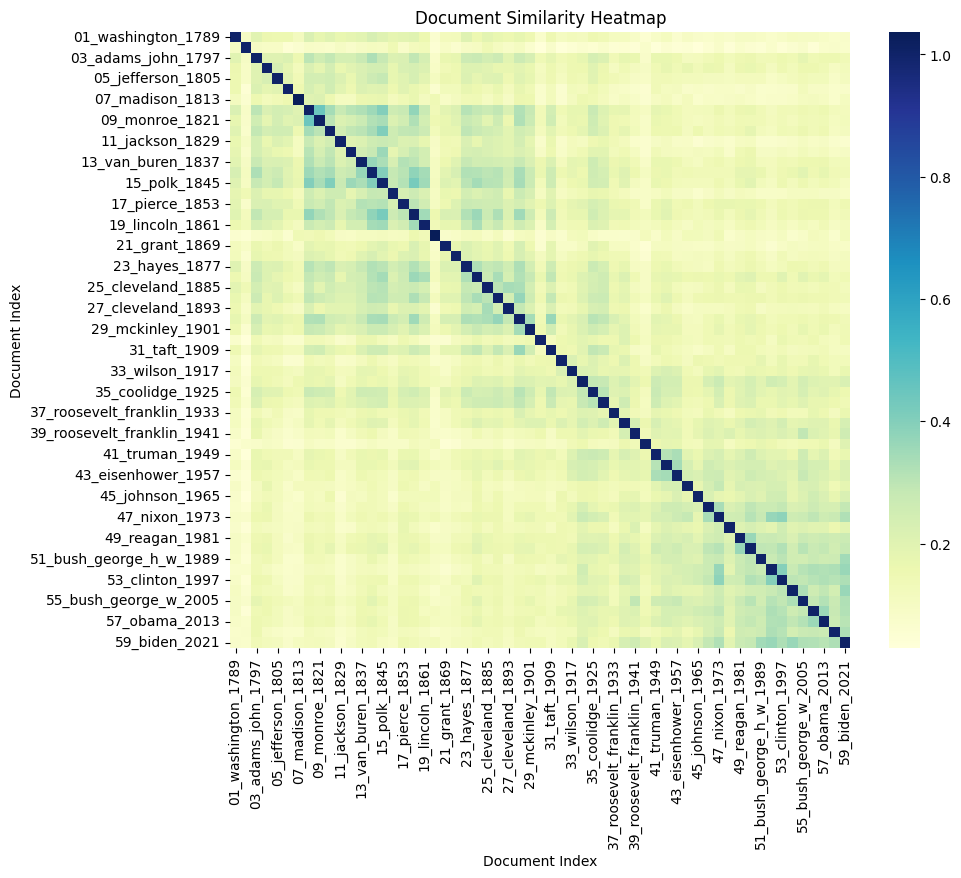

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the dot product
similarity_matrix = tfidf_df.dot(tfidf_df.T)

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="YlGnBu")
plt.title('Document Similarity Heatmap')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()


**The cell below will take the title of one of the speeches and return the 3 most similar speechs as determined by cosine similarity.**

In [ ]:


def find_most_similar_docs_by_title(tfidf_vector, target_doc_title, text_titles, top_n=3):
    # Find the index of the target document based on its title
    if target_doc_title in text_titles:
        target_doc_index = text_titles.index(target_doc_title)
    else:
        return "The document title does not exist in the corpus."

    # Calculate cosine similarity between the target document and all documents in the corpus
    cosine_similarities = cosine_similarity(tfidf_vector[target_doc_index], tfidf_vector).flatten()

    # Get the indices of the top_n most similar documents, excluding the target document itself
    most_similar_doc_indices = cosine_similarities.argsort()[-top_n-1:-1][::-1]

    # Map indices to titles
    most_similar_doc_titles = [text_titles[i] for i in most_similar_doc_indices]

    # Return the titles of the top_n most similar documents
    return most_similar_doc_titles

# Example usage
target_doc_title = "53_clinton_1997"  # Replace with your actual document title
similar_docs_titles = find_most_similar_docs_by_title(tfidf_vector, target_doc_title, text_titles)
print("Titles of the 3 most similar documents:", similar_docs_titles)


Titles of the 3 most similar documents: ['52_clinton_1993', '47_nixon_1973', '59_biden_2021']


# Latent Semantic Analysis with SVD

In [27]:
# Initialize TruncatedSVD
n_components = 12  # Choose number of components based on your needs
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Apply TruncatedSVD to the TF-IDF matrix
reduced_matrix = svd.fit_transform(tfidf_vector)

# reduced_matrix now contains the dimensionality-reduced data

In [28]:
explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total Explained Variance: {explained_variance:.2f}")


Total Explained Variance: 0.30


In [29]:

## Assuming 'tfidf_vectorizer' is your fitted vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Loop through each component (topic)
for i, comp in enumerate(svd.components_):
    # Use absolute values to get the top 10 terms with the highest influence
    terms_in_topic = [terms[j] for j in np.argsort(np.abs(comp))[-10:]]
    print(f"Topic {i+1}: {', '.join(terms_in_topic)}")


Topic 1: peace, great, country, nation, shall, states, world, america, people, government
Topic 2: constitution, public, freedom, government, states, americans, new, today, world, america
Topic 3: peace, industrial, let, conditions, economic, americans, peoples, business, union, america
Topic 4: american, business, congress, peoples, people, war, peace, nations, government, america
Topic 5: world, spirit, woe, offenses, god, peace, war, nation, let, shall
Topic 6: days, learned, nations, government, help, world, things, war, shall, freedom
Topic 7: public, congress, arrive, upbraidings, 1793, great, shall, union, states, war
Topic 8: change, men, country, people, public, constitution, war, government, america, union
Topic 9: united, government, states, dollar, war, best, man, america, let, democracy
Topic 10: country, new, know, democracy, story, dollar, constitution, government, freedom, let
Topic 11: let, leadership, sense, peace, republic, nation, br, helped, war, british
Topic 12: 

In [35]:

# Assuming you have the reduced matrix and original document list
doc_names =text_titles

# Number of top documents you want for each topic
top_n = 10

# Loop through topics
for topic_idx in range(svd.components_.shape[0]):
    # Get document contributions for the topic
    topic_column = reduced_matrix[:, topic_idx]

    # Sort documents by their contribution to the topic
    top_doc_indices = topic_column.argsort()[::-1][:top_n]

    print(f"\nTop {top_n} Documents for Topic {topic_idx + 1}:")
    for i in top_doc_indices:
        print(f"{doc_names[i]} (Contribution: {topic_column[i]:.4f})")



Top 10 Documents for Topic 1:
14_harrison_1841 (Contribution: 0.5557)
15_polk_1845 (Contribution: 0.5488)
28_mckinley_1897 (Contribution: 0.5407)
18_buchanan_1857 (Contribution: 0.5356)
08_monroe_1817 (Contribution: 0.5301)
35_coolidge_1925 (Contribution: 0.5274)
24_garfield_1881 (Contribution: 0.5260)
26_harrison_1889 (Contribution: 0.5123)
23_hayes_1877 (Contribution: 0.4999)
10_adams_john_quincy_1825 (Contribution: 0.4963)

Top 10 Documents for Topic 2:
52_clinton_1993 (Contribution: 0.4288)
59_biden_2021 (Contribution: 0.4224)
53_clinton_1997 (Contribution: 0.3916)
47_nixon_1973 (Contribution: 0.3584)
56_obama_2009 (Contribution: 0.3545)
51_bush_george_h_w_1989 (Contribution: 0.3453)
46_nixon_1969 (Contribution: 0.3428)
55_bush_george_w_2005 (Contribution: 0.3271)
58_trump_2017 (Contribution: 0.3267)
57_obama_2013 (Contribution: 0.3219)

Top 10 Documents for Topic 3:
59_biden_2021 (Contribution: 0.2095)
58_trump_2017 (Contribution: 0.2090)
52_clinton_1993 (Contribution: 0.1851)
54

# **Other sorting**

Let's drop "OO_Document Frequency" since we were just using it for illustration purposes.

In [ ]:
tfidf_df = tfidf_df.drop('00_Document Frequency', errors='ignore')

Let's reorganize the DataFrame so that the words are in rows rather than columns.

In [ ]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,01_washington_1789,000,0.000000
1,01_washington_1789,03,0.000000
2,01_washington_1789,04,0.023399
3,01_washington_1789,05,0.000000
4,01_washington_1789,100,0.000000
...,...,...,...
534830,59_biden_2021,zeal,0.000000
534831,59_biden_2021,zealous,0.000000
534832,59_biden_2021,zealously,0.000000
534833,59_biden_2021,zone,0.000000


In [ ]:
tfidf_df = tfidf_df.stack().reset_index()

In [ ]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})

To find out the top 10 words with the highest tf–idf for every story, we're going to sort by document and tfidf score and then groupby document and take the first 10 values.

In [ ]:
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

,document,term,tfidf
3728,01_washington_1789,government,0.115047
5668,01_washington_1789,ought,0.104253
4135,01_washington_1789,immutable,0.103970
4202,01_washington_1789,impressions,0.103970
6380,01_washington_1789,providential,0.103970
...,...,...,...
533972,59_biden_2021,today,0.133020
526239,59_biden_2021,americans,0.131439
531158,59_biden_2021,nation,0.127642
527830,59_biden_2021,days,0.116842


In [ ]:
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

We can zoom in on particular words and particular documents.

In [ ]:
top_tfidf[top_tfidf['term'].str.contains('women')]

,document,term,tfidf
507556,56_obama_2009,women,0.08344


It turns out that the term "women" is very distinctive in Obama's Inaugural Address.

In [ ]:
top_tfidf[top_tfidf['document'].str.contains('obama')]

,document,term,tfidf
499041,56_obama_2009,america,0.147409
503963,56_obama_2009,nation,0.120339
504024,56_obama_2009,new,0.117973
506777,56_obama_2009,today,0.113796
502241,56_obama_2009,generation,0.101664
503424,56_obama_2009,let,0.090763
503238,56_obama_2009,jobs,0.087138
500551,56_obama_2009,crisis,0.085677
502431,56_obama_2009,hard,0.083440
507556,56_obama_2009,women,0.083440


In [ ]:
top_tfidf[top_tfidf['document'].str.contains('lincoln')]

,document,term,tfidf
164941,19_lincoln_1861,constitution,0.212639
171697,19_lincoln_1861,union,0.201454
164412,19_lincoln_1861,case,0.152984
170846,19_lincoln_1861,states,0.144032
168408,19_lincoln_1861,minority,0.131812
169033,19_lincoln_1861,people,0.130353
164575,19_lincoln_1861,clause,0.125944
166898,19_lincoln_1861,government,0.125426
167960,19_lincoln_1861,law,0.124040
170498,19_lincoln_1861,shall,0.122503


In [ ]:
top_tfidf[top_tfidf['document'].str.contains('kennedy')]

,document,term,tfidf
394644,44_kennedy_1961,let,0.266121
397191,44_kennedy_1961,sides,0.264307
395801,44_kennedy_1961,pledge,0.158745
390709,44_kennedy_1961,begin,0.107037
391840,44_kennedy_1961,dare,0.107037
390476,44_kennedy_1961,ask,0.106420
398798,44_kennedy_1961,world,0.102912
393171,44_kennedy_1961,final,0.102856
395244,44_kennedy_1961,new,0.096303
393746,44_kennedy_1961,help,0.094830


## Visualize TF-IDF

We can also visualize our TF-IDF results with the data visualization library Altair.

In [ ]:
# !pip install altair

Let's make a heatmap that shows the highest TF-IDF scoring words for each president, and let's put a red dot next to two terms of interest: "war" and "peace":

The code below was contributed by [Eric Monson](https://github.com/emonson). Thanks, Eric!

In [ ]:
import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
term_list = ['war', 'peace']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600)

alt.LayerChart(...)